In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dill # for loading and saving a trained model
from nowcast_lstm.LSTM import LSTM
from nowcast_lstm.model_selection import variable_selection, hyperparameter_tuning, select_model

import warnings
warnings.filterwarnings("ignore")

# Table of Contents:
* [Basic model usage](#bullet-1)
* [Realistic model evaluation scenario (synthetic vintages)](#bullet-2)
* [Generating news / causal inference](#bullet-4)
* [Feature importance / contribution](#bullet-5)
* [Model selection](#bullet-6)
* [Variable selection](#bullet-7)
* [Hyperparameter tuning](#bullet-8)
* [Combined variable and hyperparameter selection ](#bullet-9)
* [Uncertainty Intervals ](#bullet-10)


# Basic model usage <a class="anchor" id="bullet-1"></a>
**\*note*** the model assumes stationary, seasonally adjusted series. So make sure required transformations are already performed by this point.
<br><br>
Data should be a dataframe with rows of the highest granularity of data and a date column. For example, predicting a yearly variable with monthly, quarterly, and yearly features should have a monthly dataframe. Quarterly variables should be represented as a single value during the period, with missings (`np.nan`) in between. E.g. Q1 data would be `np.nan` for January, `np.nan` for February, the value for March, etc. Yearly data would be `np.nan` for January - November, and the value for December.

In [6]:
# data read
data = pd.read_csv("data.csv", parse_dates=["date"])
data = data.loc[:, ["date", "x_jp", "x_world", "x_de", "x_uk", "ipi_cn", "x_vol_world2"]] # random subset of columns for simplicity
train_end_date = "2017-12-01" # training data through 2017
training = data.loc[data.date <= train_end_date,:]

In [7]:
# instantiating a model with 10 networks based on the previous 12 months with 50 train episodes. Defaults to mean-filling missing values. See documentation for more information on hyper-parameters.
model = LSTM(data=training, target_variable="x_world", n_timesteps=12, n_models=10, train_episodes=50)

In [8]:
# train the model, quiet=True to suppress printing of training loss
model.train(quiet=True)

In [9]:
# getting predictions on the train set
train_preds = model.predict(model.data, only_actuals_obs=True) # only_actuals_obs=True to only get predictions where there are actuals present

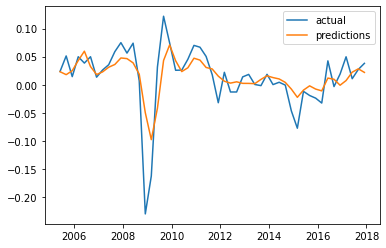

In [10]:
# performance on the train set
plt.plot(train_preds.date, train_preds.actuals, label="actual") 
plt.plot(train_preds.date, train_preds.predictions, label="predictions")
plt.legend();

In [11]:
# getting predictions on the test set
test_preds = model.predict(data, only_actuals_obs=True).loc[lambda x: x.date > train_end_date,:] # passing the full dataset, then filtering only for predictions on dates the model wasn't trained on

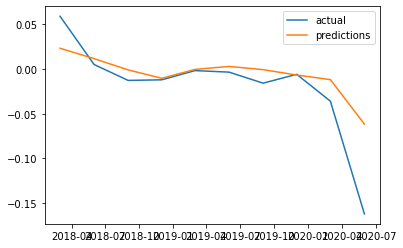

In [12]:
# performance on the test set
plt.plot(test_preds.date, test_preds.actuals, label="actual") 
plt.plot(test_preds.date, test_preds.predictions, label="predictions")
plt.legend();

In [13]:
# saving a trained model
dill.dump(model, open("trained_model.pkl", mode='wb'))

In [139]:
# loading a trained model
trained_model = dill.load(open("trained_model.pkl", "rb", -1))

# Realistic model evaluation scenario <a class="anchor" id="bullet-2"></a>
The test set above assumes full data for each test observation, this is rarely the case with economic data. The process below outlines how to check the performance of the model on different data vintages, i.e. how the data would have looked at various points in time leading up to the prediction period.

In [14]:
# data setup
data = pd.read_csv("data.csv", parse_dates=["date"])
data = data.loc[:, ["date", "x_jp", "x_world", "x_de", "x_uk", "ipi_cn", "x_vol_world2"]] # random subset of columns for simplicity
train_end_date = "2017-12-01" # training data through 2017
training = data.loc[data.date <= train_end_date,:]
target = "x_world"

### pub_lags
This is a vector of dimensions 1 x n_features. I.e. the number of independent variables in the model, this means NOT including the target variable. So for a model with a 200 x 10 dataframe, with 200 observations and 10 columns, the pub_lags vector should have 9 entries, one for each variable less the target column.
<br><br>
Its function is to provide the publication lag/schedule for each series to be able to generate data vintages via the `gen_ragged_X` function. The contents should therefore be the number of periods of lag each series experiences when published. For example, if there are three independent variables in a monthly model, GDP, exports, and the business confidence index, and they are published with a 3, 2, and 1 month lag, respectively, the lag vector should read `[3,2,1]`, or in whatever order the columns are in the original dataframe. If the target period is June, values with a lag of 2 are available until April. A value of 1 means values are available to May. A lag value of 0 means that if we are in June, June values are available. 
<br><br>
The units of the lag is the units of the original dataframe, i.e. the highest granularity of data. The monthly example above should then be extrapolated for the case of e.g. daily or quarterly data.

In [15]:
# example publication lags. Means x_jp comes out 1 month later, x_de 0 months later, x_uk 2 months later, ipi_cn 3 months later, x_vol_world2 3 months later
pub_lags = [1, 0, 2, 3, 3]

In [16]:
# model instantiation and training
model = LSTM(training, target, n_timesteps=12, n_models=10)
model.train(quiet=True)

### model assessment on vintages
The first testing example in this notebook made predictions on full datasets, i.e as if the lags for all variables was 0. This is an unrealistic scenario, so a better evaluation of a nowcasting model's performance is testing it on incomplete datasets that reflect real data publication conditions. The code below therefore uses the `pub_lags` vector and the `ragged_preds` function to create vintage datasets to test on. The below example will find performance of the model as if predictions were made 1, 2, and 3 months before the target period, in the target period, and 1 month after the target period. The appropriate prediction periods should be chosen as relevant for the use case of the nowcast. Testing continues after the target period because of publication lags. If we are nowcasting Q2 numbers and are in June, that does not mean that we have full data for June. Some figures from Q2 months may not come out until July or August, therefore the testing on vintages past the target period.

### ragged_preds
This function creates data vintages using a publication schedule, `pub_lags` vector, explained above, then generates predictions on these ragged datasets. The second parameter, `lag`, is the simulated period offset. It can be interpreted as the last period with full data relative to the target period. If we are nowcasting Q2, i.e. June, a lag of 0 simulates being in June. I.e. June is the last month with full data (for variables with lag 0). A lag of -1 simulates being in May, where May is the last full month. A lag of 1 simulates being in July, where variables with a lag of 1 now have June data as well. How many missings will be generated for a series can be calculated with `-1*(lag - variable_pub_lag)`. E.g. we set the lagged period to -2 months back, and the variable has a 1 month publication lag, `-1*(-2-1)=3`, so the last three months will be set to missing. The `data` parameter should be passed the dataset to predict, if different from the dataset the model was trained on. 
<br><br>
**note** if `"ARMA"` is chosen for `fill_ragged_edges_func`, `ragged_preds` will take significantly longer to calculate, as ARMA models have to be fit on every observation's data vintages.
<br><br>
Generally we should expect to see evaluation metrics get better the further ahead in time we move, as more data is available.

In [17]:
# performance on a single vintage, 2 months back of target period
lag = -2
test_preds = model.ragged_preds(pub_lags, lag, data=data).loc[lambda x: x.date > train_end_date] # passing the full dataset, then filtering only for predictions on dates the model wasn't trained on

# different evaluation metrics
RMSE = np.sqrt(np.mean((test_preds.actuals - test_preds.predictions)**2))
MAE = np.mean(np.abs((test_preds.actuals - test_preds.predictions)))

print(f"RMSE: {np.round(RMSE, 4)}")
print(f"MAE: {np.round(MAE, 4)}")

RMSE: 0.0243
MAE: 0.0204


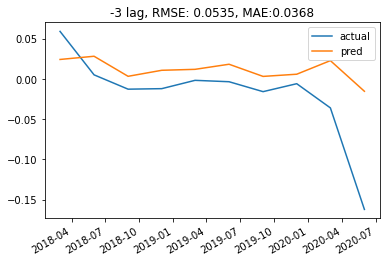

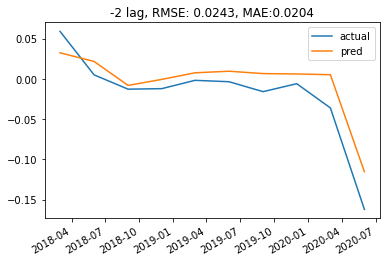

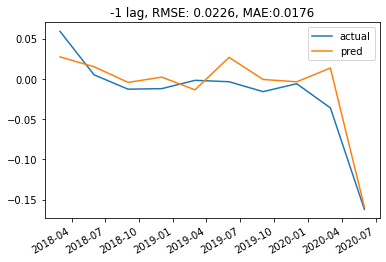

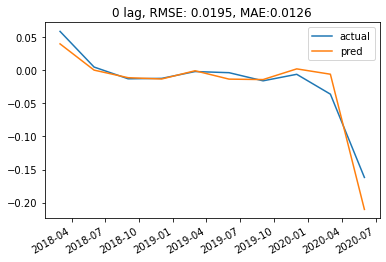

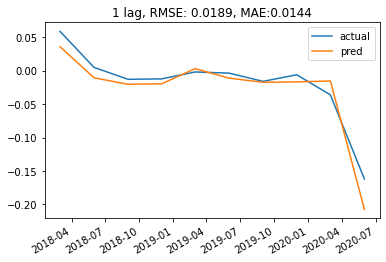

In [18]:
# visualization of performance over time, to see how performance develops
for lag in [-3, -2, -1, 0, 1]: # 3 months back, 2 months back, 1 month back, month-of, 1 month ahead vintages
    test_preds = model.ragged_preds(pub_lags, lag, data=data).loc[lambda x: x.date > train_end_date] # passing the full dataset, then filtering only for predictions on dates the model wasn't trained on
    
    # different evaluation metrics, test_data.y is actuals
    RMSE = np.sqrt(np.mean((test_preds.actuals - test_preds.predictions)**2))
    MAE = np.mean(np.abs((test_preds.actuals - test_preds.predictions)))
    
    # plotting results
    fig, ax = plt.subplots()
    fig.autofmt_xdate()
    
    ax.plot(test_preds.date, test_preds.actuals, label="actual")
    ax.plot(test_preds.date, test_preds.predictions, label=f"pred")
    plt.title(f"{lag} lag, RMSE: {np.round(RMSE,4)}, MAE:{np.round(MAE,4)}")
    plt.legend()
    plt.show()

In [145]:
# to make sure the right values are being set to missing, the gen_ragged_X function can be called to see what's being passed for ragged prediction
model.X[0,:,0] # the X object has three dimensions, n_obs x n_timesteps x n_features, this is the first observation, the first feature

array([-1.94665401e-02,  6.41786089e-05,  7.21203830e-03,  1.06082605e-02,
        3.92971848e-02, -1.48268313e-02,  1.09373230e-02, -2.74475538e-03,
        3.02965665e-02, -3.27576576e-03, -1.02967146e-02, -1.39156223e-02])

In [146]:
# the gen_ragged_X function returns a ragged X and the corresponding y. We select [0] to get the ragged X, then [0,:,0] to get the first observation, the first feature
# we see the last two observations have been replace with the series mean, because we have a lag of -1, and the first feature (x_jp) has a lag of 1, -1*(-1-1) = the last 2 values set to missing, then replaced with the mean
# if we had set fill_ragged_edges_func in model instantiation to "ARMA", the last two values would have been replaced with ARMA estimations instead of the series mean (the default)
model.gen_ragged_X(pub_lags, -1)[0][0,:,0]

array([-1.94665401e-02,  6.41786089e-05,  7.21203830e-03,  1.06082605e-02,
        3.92971848e-02, -1.48268313e-02,  1.09373230e-02, -2.74475538e-03,
        3.02965665e-02, -3.27576576e-03,  4.18520337e-03,  4.18520337e-03])

# Different filling NA options <a class="anchor" id="bullet-3"></a>
The default behavior of the model is to fill missings/NAs with the mean of the series. There are however other approaches, this section will outline different implementations available in the library.

### 2 types of missing values:
- _within-series missings_: E.g. quarterly data that is forced to be monthly will have NAs in between observations, or if a series just has some missing values within it. Fill these with the `fill_na_func` parameter in `LSTM` instantiation. The function must take a series and return a scalar, e.g. `np.nanmean`, `np.nanmedian`, etc.

- _ragged edges_: I.e. observations that haven't come out yet because of publication lag. These happen exclusively at the end of the series. Fill these with the `fill_ragged_edges_func` parameter in `LSTM` instantiation. The function must take a series and return a scalar, e.g. `np.nanmean`, `np.nanmedian`, or enter `"ARMA"` to use ARMA estimation. Don't pass anything to use the same function as passed to `fill_na_func`.

In [147]:
# data setup
data = pd.read_csv("data.csv", parse_dates=["date"])
data = data.loc[:, ["date", "x_jp", "x_de", "ipi_cn", "x_vol_world2", "x_world"]] # random subset of columns for simplicity
features = ["x_jp", "x_de", "ipi_cn", "x_vol_world2"]
target = "x_world"

In [148]:
# looking at the end of the dataset, we can see some ragged edges
data.loc[:, features].tail(10)

x_jp      x_de  ipi_cn  x_vol_world2
217  0.027627  0.004619     NaN           NaN
218 -0.014492 -0.099137  -0.011     -0.017065
219 -0.113030 -0.266919   0.039           NaN
220 -0.041397  0.104712   0.044           NaN
221  0.009955  0.169252   0.048     -0.150345
222  0.069343  0.069704     NaN           NaN
223  0.057047  0.061412     NaN           NaN
224  0.038700  0.026040     NaN           NaN
225  0.029190       NaN     NaN           NaN
226       NaN       NaN     NaN           NaN

In [149]:
# we can fill these using the mean of the series. x_vol_world2, a quarterly variable, has additionally had its within-series missings filled with the series mean as well
tmp = LSTM(data, "x_world", n_timesteps=12, fill_na_func=np.nanmean).dataset["na_filled_dataset"][-10:,:-1] # pass fill_na_func=np.nanmedian to use the median
pd.DataFrame(tmp, columns=features)

x_jp      x_de    ipi_cn  x_vol_world2
0  0.027627  0.004619  0.115697      0.004903
1 -0.014492 -0.099137 -0.011000     -0.017065
2 -0.113030 -0.266919  0.039000      0.004903
3 -0.041397  0.104712  0.044000      0.004903
4  0.009955  0.169252  0.048000     -0.150345
5  0.069343  0.069704  0.115697      0.004903
6  0.057047  0.061412  0.115697      0.004903
7  0.038700  0.026040  0.115697      0.004903
8  0.029190  0.005243  0.115697      0.004903
9  0.003397  0.005243  0.115697      0.004903

In [150]:
# ragged edges can also be filled by ARMA estimation, in the below example ARMA parameters were estimated using `pmdarima.arima.auto_arima` then fit to the data to fill ragged edges
# ragged edges have now been filled using ARMA models for each series. x_vol_world2 within-series missings continue to be filled in with the series mean as passed to the `fill_na_func`
tmp = LSTM(data, "x_world", n_timesteps=12, fill_na_func=np.nanmean, fill_ragged_edges_func="ARMA").dataset["na_filled_dataset"][-10:,:-1]
pd.DataFrame(tmp, columns=features)

x_jp      x_de    ipi_cn  x_vol_world2
0  0.027627  0.004619  0.115697      0.004903
1 -0.014492 -0.099137 -0.011000     -0.017065
2 -0.113030 -0.266919  0.039000      0.004903
3 -0.041397  0.104712  0.044000      0.004903
4  0.009955  0.169252  0.048000     -0.150345
5  0.069343  0.069704  0.048205      0.004903
6  0.057047  0.061412  0.049725      0.004903
7  0.038700  0.026040  0.051523     -0.128865
8  0.029190  0.007008  0.052899      0.004903
9  0.012272  0.005250  0.054284      0.004903

### Also used in `gen_ragged_X`/`ragged_preds` functions
The NA-filling parameters specified in model instantiation are also used in the ragged functions, which artifically create ragged edges based on publication lags.

In [151]:
# this is what the last observation in the data looks like, i.e. no missings
model = LSTM(data, "x_world", n_timesteps=12, fill_na_func=np.nanmean, fill_ragged_edges_func=np.nanmean)
tmp = model.X[-1,:,:]
pd.DataFrame(tmp, columns=features)

x_jp      x_de    ipi_cn  x_vol_world2
0  -0.014974  0.001702  0.048000      0.004903
1  -0.029245 -0.012135  0.044000      0.004903
2  -0.014317  0.005756  0.058000      0.004903
3  -0.045167  0.011326  0.047000      0.004903
4  -0.005281 -0.017942  0.062000      0.004903
5  -0.006490  0.012664  0.069000     -0.001741
6  -0.032822 -0.006319  0.115697      0.004903
7   0.027627  0.004619  0.115697      0.004903
8  -0.014492 -0.099137 -0.011000     -0.017065
9  -0.113030 -0.266919  0.039000      0.004903
10 -0.041397  0.104712  0.044000      0.004903
11  0.009955  0.169252  0.048000     -0.150345

In [152]:
# this is what the last observation in the artificial ragged data looks like with a lag of -1. 
# E.g. the last 2 values for x_jp have been replaced by the mean, because it has a pub_lag of 1 plus the lag of -1 means two missings, etc.
tmp = model.gen_ragged_X(pub_lags=[1,2,1,3], lag=-1)[0][-1,:,:]
pd.DataFrame(tmp, columns=features)

x_jp      x_de    ipi_cn  x_vol_world2
0  -0.014974  0.001702  0.048000      0.004903
1  -0.029245 -0.012135  0.044000      0.004903
2  -0.014317  0.005756  0.058000      0.004903
3  -0.045167  0.011326  0.047000      0.004903
4  -0.005281 -0.017942  0.062000      0.004903
5  -0.006490  0.012664  0.069000     -0.001741
6  -0.032822 -0.006319  0.115697      0.004903
7   0.027627  0.004619  0.115697      0.004903
8  -0.014492 -0.099137 -0.011000      0.004903
9  -0.113030  0.005243  0.039000      0.004903
10  0.003397  0.005243  0.115697      0.004903
11  0.003397  0.005243  0.115697      0.004903

In [153]:
# if the model has been instantiated with ARMA for filling ragged edges, the artificial missings would have been replaced with ARMA estimations, not the mean
# the ARMA method takes longer to generate the artificial ragged data because ARMA models need to be fit on all the artificial vintages
model = LSTM(data, "x_world", n_timesteps=12, fill_na_func=np.nanmean, fill_ragged_edges_func="ARMA")
model.train(quiet=True)
tmp = model.gen_ragged_X(pub_lags=[1,2,1,3], lag=-1)[0][-1,:,:]
pd.DataFrame(tmp, columns=features)

Training model 1


x_jp      x_de    ipi_cn  x_vol_world2
0  -0.014974  0.001702  0.048000      0.004903
1  -0.029245 -0.012135  0.044000      0.004903
2  -0.014317  0.005756  0.058000      0.004903
3  -0.045167  0.011326  0.047000      0.004903
4  -0.005281 -0.017942  0.062000      0.004903
5  -0.006490  0.012664  0.069000     -0.001741
6  -0.032822 -0.006319  0.115697      0.004903
7   0.027627  0.004619  0.115697      0.004903
8  -0.014492 -0.099137 -0.011000     -0.003492
9  -0.113030  0.002923  0.039000      0.004903
10 -0.019894  0.004622  0.043268      0.004903
11 -0.026520  0.004622  0.034734     -0.002268

In [154]:
# time can be saved by passing dates to `start_date` and/or `end_date` on either `ragged_preds` or `gen_ragged_X` to only generate ragged predictions for e.g. a test set, not all dates
# ragged predictions on all dates
model.ragged_preds(pub_lags=[1,2,1,3], lag=-1)

date   actuals  predictions
0  2005-06-01  0.023618     0.042007
1  2005-09-01  0.051245     0.020240
2  2005-12-01  0.014421     0.046504
3  2006-03-01  0.049846     0.037039
4  2006-06-01  0.038543     0.042572
..        ...       ...          ...
56 2019-06-01 -0.003545     0.013097
57 2019-09-01 -0.015856    -0.002660
58 2019-12-01 -0.005995    -0.027048
59 2020-03-01 -0.036013    -0.009311
60 2020-06-01 -0.161963    -0.080053

[61 rows x 3 columns]

In [155]:
# ragged predictions on just 2017-2019 for faster calculation
model.ragged_preds(pub_lags=[1,2,1,3], lag=-1, start_date="2017-01-01", end_date="2019-12-01")

date   actuals  predictions
0  2017-03-01  0.049740    -0.020026
1  2017-06-01  0.010703     0.020635
2  2017-09-01  0.027313     0.003040
3  2017-12-01  0.038043     0.001452
4  2018-03-01  0.058902     0.010815
5  2018-06-01  0.004988     0.020817
6  2018-09-01 -0.012785    -0.022845
7  2018-12-01 -0.012139    -0.004328
8  2019-03-01 -0.001823    -0.015770
9  2019-06-01 -0.003545     0.013097
10 2019-09-01 -0.015856    -0.002660
11 2019-12-01 -0.005995    -0.027048

ARMA models can also be fit on a smaller subset of series history by passing a shorter dataframe to `model.predict(data=short_df)` or `model.ragged_preds(data=short_df)`. If the model was trained on data from 2000-2015, `short_df` could be the data just from e.g. 2015-2018 to only use series history from 2015 for the ARMA models. Passing a dataframe with data from 2000-2018 would use the full series history.

# Generating news / causal inference <a class="anchor" id="bullet-4"></a>
The library provides a means of getting some causal inference on the change in the LSTM's outputs as new data are released, similar in concept to the [Fed's nowcasts](https://www.newyorkfed.org/research/policy/nowcast.html), which use dynamic factor models. Given an old and a new data release, the model's predictions will change. The method of generating each variable's contribution to this change is the following: for each column with new data, that data is held out of the latest dataset, then predictions are gotten. The difference between this prediction and the prediction with the full new dataset is considered this variable's contribution to the change in prediction. The process is repeated for all variables, and finally the process is run for the new dataset, but with all data that was missing in the old dataset missing as well. In this way, the contribution of data revisions can be ascertained. These contributions are the "news" column of the "news" dataframe output by the function. These are then scaled so that their sum equals the actual difference between old and new predictions. In most cases, this scaling factor, the "holdout_discrepency" of the function output, should be close to 1.



In [156]:
train_end_date = "2017-12-01" # training data through 2017
training = data.loc[data.date <= train_end_date,:]
model = LSTM(training, target, n_timesteps=12, n_models=1)
model.train(quiet=True)

Training model 1


In [157]:
# new data is our latest dataset
new_data = data.copy()
# old data is our previous dataset
old_data = data.copy()
old_data.loc[old_data.date >= "2020-09-01", ["x_jp", "x_de"]] = np.nan
old_data.loc[old_data.date == "2020-08-01", ["x_jp"]] = 0.062

Our old data (e.g. last week's data) didn't have data for x_de or x_jp for September 2020, while it had a higher value for x_jp in August 2020, which was revised downwards in the latest data. Make sure both datasets have the target variable in them, add the time periods necessary (with missings for all variables) if they are missing from one or the other dataset.

In [158]:
old_data.tail()

date      x_jp      x_de  ipi_cn  x_vol_world2  x_world
222 2020-07-01  0.069343  0.069704     NaN           NaN      NaN
223 2020-08-01  0.062000  0.061412     NaN           NaN      NaN
224 2020-09-01       NaN       NaN     NaN           NaN      NaN
225 2020-10-01       NaN       NaN     NaN           NaN      NaN
226 2020-11-01       NaN       NaN     NaN           NaN      NaN

Our new data has new information, so new data were released

In [159]:
new_data.tail()

date      x_jp      x_de  ipi_cn  x_vol_world2  x_world
222 2020-07-01  0.069343  0.069704     NaN           NaN      NaN
223 2020-08-01  0.057047  0.061412     NaN           NaN      NaN
224 2020-09-01  0.038700  0.026040     NaN           NaN      NaN
225 2020-10-01  0.029190       NaN     NaN           NaN      NaN
226 2020-11-01       NaN       NaN     NaN           NaN      NaN

We can run the .gen_news function to see the impact of these changes on the model's prediction

In [160]:
news = model.gen_news("2020-09-01", old_data, new_data)
news["news"]

column      news  scaled_news
0       x_jp  0.002676     0.002712
1       x_de  0.003014     0.003054
2  revisions -0.000684    -0.000693

We can also get the old prediction and the new prediction, as well as the holdout discrepency from the "news" dictionary object

In [161]:
news

{'news':       column      news  scaled_news
 0       x_jp  0.002676     0.002712
 1       x_de  0.003014     0.003054
 2  revisions -0.000684    -0.000693,
 'old_pred': 0.11507246643304825,
 'new_pred': 0.12014523148536682,
 'holdout_discrepency': 0.9870251375109238}

The sum of the "scaled_news" column should sum to exactly the difference between the old and new predictions

In [162]:
print(f"Sum of the (unscaled) news column: {round(news['news'].news.sum(), 6)}")
print(f"Sum of the scaled_news column: {round(news['news'].scaled_news.sum(), 6)}")
print(f"Difference between old and new predictions: {round(news['new_pred'] - news['old_pred'], 6)}")

Sum of the (unscaled) news column: 0.005007
Sum of the scaled_news column: 0.005073
Difference between old and new predictions: 0.005073


If we want to generate news for December 2020 predictions (Q4), we have to first add that date to both datasets

In [163]:
new_data.tail()

date      x_jp      x_de  ipi_cn  x_vol_world2  x_world
222 2020-07-01  0.069343  0.069704     NaN           NaN      NaN
223 2020-08-01  0.057047  0.061412     NaN           NaN      NaN
224 2020-09-01  0.038700  0.026040     NaN           NaN      NaN
225 2020-10-01  0.029190       NaN     NaN           NaN      NaN
226 2020-11-01       NaN       NaN     NaN           NaN      NaN

In [164]:
# for adding months to data
from dateutil.relativedelta import relativedelta
new_data.loc[len(new_data), "date"] = np.max(new_data.date) + relativedelta(months=1)
old_data.loc[len(old_data), "date"] = np.max(old_data.date) + relativedelta(months=1)
new_data.tail()

date      x_jp      x_de  ipi_cn  x_vol_world2  x_world
223 2020-08-01  0.057047  0.061412     NaN           NaN      NaN
224 2020-09-01  0.038700  0.026040     NaN           NaN      NaN
225 2020-10-01  0.029190       NaN     NaN           NaN      NaN
226 2020-11-01       NaN       NaN     NaN           NaN      NaN
227 2020-12-01       NaN       NaN     NaN           NaN      NaN

In [165]:
news = model.gen_news("2020-12-01", old_data, new_data)
news["news"]

column      news  scaled_news
0       x_jp  0.007920     0.007979
1       x_de  0.005481     0.005522
2  revisions -0.000375    -0.000378

# Feature importance / contribution <a class="anchor" id="bullet-5"></a>
One big drawback of neural networks is typically their "blackbox" nature, or lack of insight into why they make the predictions they do. In a linear model, this is quite straightforward via each variable's coefficient, which tells that variable's impact on the model's predictions. There are ways to approximate this feature contribution for neural networks, however. Permutation feature importance is one method. See [this page](https://christophm.github.io/interpretable-ml-book/feature-importance.html#feature-importance) for more information on the methodology. In this library, feature contribution is calculated as follows: 
- RMSE is calculated on the train set with full information
- then, each variable is individually replaced with its mean, so that no useful information for that variable remains and train set predictions are obtained with that variable missing
- RMSE from this permuted model is then compared as a ratio to RMSE with full information and recorded as that variable's contribution
- finally, all contributions are scaled to the highest contributing variable's impact, so that variable has a value of 1. A negative value for a variable implies that it actually hurts performance on the train set.

In [ ]:
# data setup
data = pd.read_csv("data.csv", parse_dates=["date"])
data = data.loc[:, ["date", "x_jp", "x_world", "x_de", "x_uk", "ipi_cn", "x_vol_world2"]] # random subset of columns for simplicity
train_end_date = "2017-12-01" # training data through 2017
training = data.loc[data.date <= train_end_date,:]
target = "x_world"

In [21]:
model = LSTM(training, target, n_timesteps=12, n_models=10) # default model
model.train(quiet=True)

In [24]:
contribution = model.feature_contribution()
contribution

feature  scaled_contribution
0          x_uk             1.000000
1          x_de             0.911605
2          x_jp             0.085204
3        ipi_cn             0.067133
4  x_vol_world2             0.029185

We can see this model obtains most of its information from the `x_uk` and `x_de` variables. The rest are relatively less important.

<BarContainer object of 5 artists>

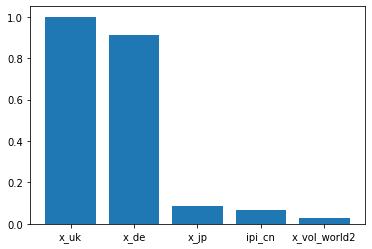

In [25]:
# visualized graphically
plt.bar(contribution.feature, contribution.scaled_contribution)

We can verify this quickly by comparing the model's performance without one of its most important variables, `x_uk`, to its performance without one of its least important.

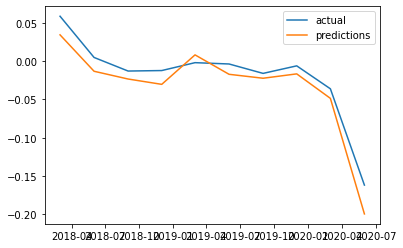

In [26]:
# performance on the test set with all variables
test_preds = model.predict(data, only_actuals_obs=True).loc[lambda x: x.date > train_end_date,:] # passing the full dataset, then filtering only for predictions on dates the model wasn't trained on

plt.plot(test_preds.date, test_preds.actuals, label="actual") 
plt.plot(test_preds.date, test_preds.predictions, label="predictions")
plt.legend();

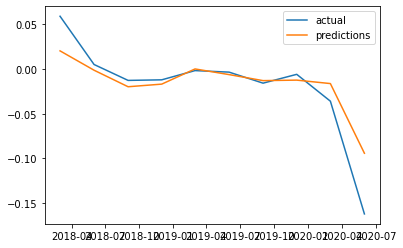

In [30]:
# performance on the test set without the important "x_uk" variable
tmp_data = data.copy()
tmp_data["x_uk"] = np.nanmean(tmp_data["x_uk"])
test_preds = model.predict(tmp_data, only_actuals_obs=True).loc[lambda x: x.date > train_end_date,:] # passing the full dataset, then filtering only for predictions on dates the model wasn't trained on

plt.plot(test_preds.date, test_preds.actuals, label="actual") 
plt.plot(test_preds.date, test_preds.predictions, label="predictions")
plt.legend();

The model now has trouble predicting the large drops in Q1 and Q2 2020.

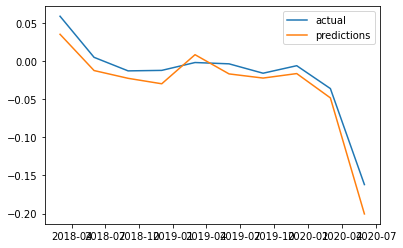

In [31]:
# performance on the test set without the unimportant "x_vol_world2" variable
tmp_data = data.copy()
tmp_data["x_vol_world2"] = np.nanmean(tmp_data["x_vol_world2"])
test_preds = model.predict(tmp_data, only_actuals_obs=True).loc[lambda x: x.date > train_end_date,:] # passing the full dataset, then filtering only for predictions on dates the model wasn't trained on

plt.plot(test_preds.date, test_preds.actuals, label="actual") 
plt.plot(test_preds.date, test_preds.predictions, label="predictions")
plt.legend();

Conversely, removing an unimportant variable hardly changes the model's predictions at all.

# Model selection <a class="anchor" id="bullet-6"></a>
One of the biggest drawbacks of the LSTM methodology, especially to the new practitioner or those unfamiliar with the machine learning paradigm, is the fact that LSTMs need to be hyperparameter tuned. If there is a large pool of potential input variables for a model, the best-performing variables also have to be selected, though this is true of any methodology. The library substantially eases that process by providing automatic ways to perform variable selection, hyperparameter tuning, and both together.

## Variable selection <a class="anchor" id="bullet-7"></a>
For a given set of hyperparameters, the library can select a set of well-performing variables for the model. It works via a two-step forward select/additive process, also known as recursive feature addition ([RFA](https://atrium.lib.uoguelph.ca/xmlui/handle/10214/10315)), the first step to determine the initial ordering of variables, the second to systematically add variables and keep them if they improve performance. There are two options for the first step. The first, obtained by passing `"feature_contribution"` to the   `initial_ordering` parameter, is to train a model with all the variables and use their feature contribution as the order, most contributing first. The second option is a univariate modelling approach, obtained by passing `"univariate"` to the `initial_ordering` parameter, where a univariate LSTM model is fitted for each variable. Performance is then recorded for each univariate model, and the order of best-performing to worst-performing variable is used for the second, multivariate step. In the multivariate step, the model starts with just the first/best column in the first step. The second-best performing variable is then added to the model. If this new model obtains better performance than the previous best model, the variable is added to the new best model. If performance does not improve by adding the variable, the variable is not included in the model and the process continues.

This methodology has a couple of benefits. Firstly, it does not require the user to specify a desired number of variables. This is determined automatically via the process described above. Secondly, its runtime is bound to 2 x the number of possible variables for univariate initialization, one pass for the univariate step, one pass for the multivariate step. 1 x the number of possible variables for feature contribution initialization. Thirdly, it emphasizes a parsimonious model.

The implementation in the library can be made quite robust by combining multiple rolling folds with assessing on artificial vintages if publication lags are provided. An explanation of the `variable_selection` function's hyperparameters:
- **same parameters as any LSTM model**: all parameters before `n_folds` are the same hyperparameters as in any LSTM model.
- **n_folds**: how many folds for rolling fold validation to do. More is a more robust selection process.
- **init_test_size** A number between 0 and 1. What proportion of the data to use for testing at the first fold. E.g., 0.2 will use 20% of the data for testing. 0.2, when combined with two folds, will test with one fold with an 80-20 train-test split, and one fold with a 90-10 test split.
- **pub_lags**: A list of publication lags, exactly the same as explained in the `ragged_preds` section above. Ignore to test on only complete information. If `pub_lags` is passed, variables will be selected additionally on their performance on artificial data vintages, improving robustness of selection.
- **lags**: A list of lags to consider when selecting variables. E.g., `[-2, 0, 2]` would additionally consider model performance at 2 months before, month of, and two months after prediction period when selecting variables.
- **performance_metric**: "RMSE" for root mean square error, "MAE" for mean absolute error, or "AICc" for corrected Akaike Information Criterion.
- **alpha**: A number between 0 and 1. 0 implies no penalty for adding additional variables, so if the model is better by even 0.0000001, the variable will be added. 1 implies maximum penalty for adding an additional regressor. Penalty is derived from adjusted R2 penalty. Not relevant for "AICc", which already includes its own penalty for additional variables.
- **initial_ordering**: "feature_contribution" for feature contribution initialization (default), "univariate" for univariate model initialization.
- **quiet**: Boolean determining whether or not to print out variable selection progress.

In [32]:
# data setup
data = pd.read_csv("data.csv", parse_dates=["date"])
data = data.loc[:, ["date", "x_jp", "x_world", "x_de", "x_uk", "ipi_cn", "x_vol_world2"]] # random subset of columns for simplicity
train_end_date = "2017-12-01" # training data through 2017
training = data.loc[data.date <= train_end_date,:]
target = "x_world"

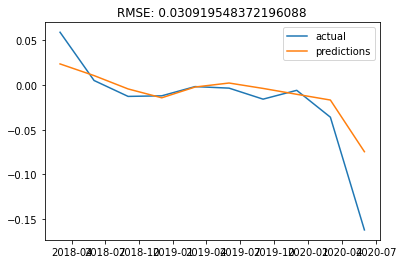

In [38]:
# performance on the test set with all variables as a baseline
model = LSTM(training, target, n_timesteps=12, n_models=10, train_episodes=50)
model.train(quiet=True)

test_preds = model.predict(data, only_actuals_obs=True).loc[lambda x: x.date > train_end_date,:] # passing the full dataset, then filtering only for predictions on dates the model wasn't trained on

# rmse on the test set of hte model
rmse = np.sqrt(np.nanmean((test_preds.predictions - test_preds.actuals)**2))

plt.plot(test_preds.date, test_preds.actuals, label="actual") 
plt.plot(test_preds.date, test_preds.predictions, label="predictions")
plt.legend()
plt.title(f"RMSE: {rmse}");

In [39]:
selected_variables = variable_selection(training, target, n_timesteps=12, n_models=10, train_episodes=50, n_folds=5, init_test_size=0.45)

univariate stage: 0 / 5 columns
univariate stage: 1 / 5 columns
univariate stage: 2 / 5 columns
univariate stage: 3 / 5 columns
univariate stage: 4 / 5 columns
multivariate stage: 0 / 5 columns
multivariate stage: 1 / 5 columns
multivariate stage: 2 / 5 columns
multivariate stage: 3 / 5 columns
multivariate stage: 4 / 5 columns


In [40]:
# the x_vol_world2 variable was dropped via the selection process. There were only 5 variables to choose from initially, this difference between the number of selected variables and the size of the pool can be much more dramatic with many more variables 
selected_variables

(['x_uk', 'x_jp', 'x_de', 'ipi_cn'], 0.03387981510864903)

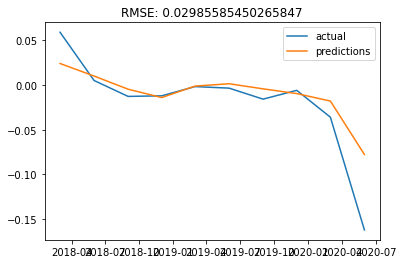

In [44]:
# performance on the test set with only the selected variables
model2 = LSTM(training.loc[:, ["date", target] + selected_variables[0]], target, n_timesteps=12, n_models=10, train_episodes=50)
model2.train(quiet=True)

test_preds = model2.predict(data.loc[:, ["date", target] + selected_variables[0]], only_actuals_obs=True).loc[lambda x: x.date > train_end_date,:] # passing the full dataset, then filtering only for predictions on dates the model wasn't trained on

# rmse on the test set of hte model
rmse = np.sqrt(np.nanmean((test_preds.predictions - test_preds.actuals)**2))

plt.plot(test_preds.date, test_preds.actuals, label="actual") 
plt.plot(test_preds.date, test_preds.predictions, label="predictions")
plt.legend()
plt.title(f"RMSE: {rmse}");

We can see the new model with a selected subsample of variables actually obtains a slightly better RMSE with one less variable. Again, the process is not very pronounced here because of starting with such a small initial variable pool. With this small number of variables you can probably just use all variables in the model. But it becomes very relevant when there are dozens or hundreds of potential input variables.

## Hyperparameter tuning <a class="anchor" id="bullet-8"></a>
For a given set of variables, the library can select a set of well-performing hyperparameters for the model. It works the same as any machine learning grid search algorithm. Lists of hyperparameter options are passed to the function, and it will return the performance of all the different hyperparamter combinations, sorted from best-performing to worst. The best-performing can then be taken for the final model.

The implementation in the library can be made quite robust by combining multiple rolling folds with assessing on artificial vintages if publication lags are provided. An explanation of the `variable_selection` function's hyperparameters:
- **same parameters as any LSTM model**: all parameters before `n_folds` are the same hyperparameters as in any LSTM model, just suffixed with the word `_grid`, to make clear a list of options should be passed. To pass a single option, pass it as a list, e.g., `n_layers_grid = [1]`.
- **n_folds**: how many folds for rolling fold validation to do. More is a more robust selection process.
- **init_test_size** A number between 0 and 1. What proportion of the data to use for testing at the first fold. E.g., 0.2 will use 20% of the data for testing. 0.2, when combined with two folds, will test with one fold with an 80-20 train-test split, and one fold with a 90-10 test split.
- **pub_lags**: A list of publication lags, exactly the same as explained in the `ragged_preds` section above. Ignore to test on only complete information. If `pub_lags` is passed, variables will be selected additionally on their performance on artificial data vintages, improving robustness of selection.
- **lags**: A list of lags to consider when selecting variables. E.g., `[-2, 0, 2]` would additionally consider model performance at 2 months before, month of, and two months after prediction period when selecting variables.
- **performance_metric**: "RMSE" for root mean square error, "MAE" for mean absolute error, or "AICc" for corrected Akaike Information Criterion.
- **alpha**: A number between 0 and 1. 0 implies no penalty for adding additional variables, so if the model is better by even 0.0000001, the variable will be added. 1 implies maximum penalty for adding an additional regressor. Penalty is derived from adjusted R2 penalty. Not relevant for "AICc", which already includes its own penalty for additional variables.
- **quiet**: Boolean determining whether or not to print out variable selection progress.

In [45]:
# data setup
data = pd.read_csv("data.csv", parse_dates=["date"])
data = data.loc[:, ["date", "x_jp", "x_world", "x_de", "x_uk", "ipi_cn", "x_vol_world2"]] # random subset of columns for simplicity
train_end_date = "2017-12-01" # training data through 2017
training = data.loc[data.date <= train_end_date,:]
target = "x_world"

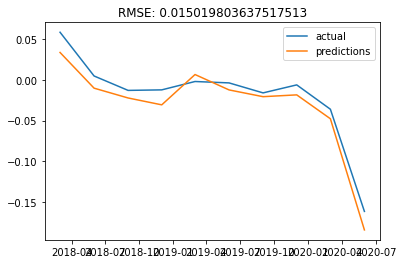

In [46]:
# performance on the test set with default hyperparameters as a baseline
model = LSTM(training, target, n_timesteps=12, n_models=10)
model.train(quiet=True)

test_preds = model.predict(data, only_actuals_obs=True).loc[lambda x: x.date > train_end_date,:] # passing the full dataset, then filtering only for predictions on dates the model wasn't trained on

# rmse on the test set of hte model
rmse = np.sqrt(np.nanmean((test_preds.predictions - test_preds.actuals)**2))

plt.plot(test_preds.date, test_preds.actuals, label="actual") 
plt.plot(test_preds.date, test_preds.predictions, label="predictions")
plt.legend()
plt.title(f"RMSE: {rmse}");

In [47]:
tuning_results = hyperparameter_tuning(training, target, n_models=10, n_timesteps_grid = [6, 12], train_episodes_grid = [100, 200], batch_size_grid = [30], n_hidden_grid = [10, 20], n_layers_grid = [2], n_folds=2, init_test_size = 0.3)

tuning: 0 / 8
tuning: 1 / 8
tuning: 2 / 8
tuning: 3 / 8
tuning: 4 / 8
tuning: 5 / 8
tuning: 6 / 8
tuning: 7 / 8


In [50]:
tuning_results

hyper_params  performance
0  {'n_models': 10, 'n_timesteps': 6, 'fill_na_fu...     0.025524
1  {'n_models': 10, 'n_timesteps': 6, 'fill_na_fu...     0.025528
2  {'n_models': 10, 'n_timesteps': 6, 'fill_na_fu...     0.026165
3  {'n_models': 10, 'n_timesteps': 6, 'fill_na_fu...     0.026498
4  {'n_models': 10, 'n_timesteps': 12, 'fill_na_f...     0.027223
5  {'n_models': 10, 'n_timesteps': 12, 'fill_na_f...     0.027309
6  {'n_models': 10, 'n_timesteps': 12, 'fill_na_f...     0.027683
7  {'n_models': 10, 'n_timesteps': 12, 'fill_na_f...     0.028412

In [49]:
tuning_results.iloc[0,0]

{'n_models': 10,
 'n_timesteps': 6,
 'fill_na_func': <function numpy.nanmean(a, axis=None, dtype=None, out=None, keepdims=<no value>)>,
 'fill_ragged_edges_func': <function numpy.nanmean(a, axis=None, dtype=None, out=None, keepdims=<no value>)>,
 'train_episodes': 100,
 'batch_size': 30,
 'decay': 0.98,
 'n_hidden': 20,
 'n_layers': 2,
 'dropout': 0,
 'criterion': '',
 'optimizer': '',
 'optimizer_parameters': {'lr': 0.01}}

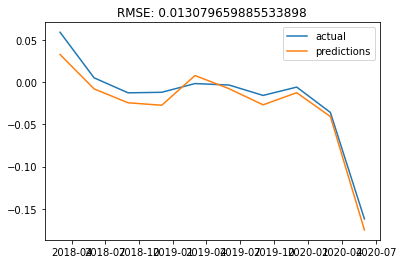

In [52]:
# performance on the test set with selected hyperparameters
model2 = LSTM(training, target, n_timesteps=6, n_models=10, train_episodes=100, n_hidden=20, n_layers=2)
model2.train(quiet=True)

test_preds = model2.predict(data, only_actuals_obs=True).loc[lambda x: x.date > train_end_date,:] # passing the full dataset, then filtering only for predictions on dates the model wasn't trained on

# rmse on the test set of hte model
rmse = np.sqrt(np.nanmean((test_preds.predictions - test_preds.actuals)**2))

plt.plot(test_preds.date, test_preds.actuals, label="actual") 
plt.plot(test_preds.date, test_preds.predictions, label="predictions")
plt.legend()
plt.title(f"RMSE: {rmse}");

We see that even with this very light hyperparameter tuning, just 8 permutations, we were able to get slightly better results on the test set.

## Combined variable and hyperparameter selection <a class="anchor" id="bullet-9"></a>
If we know neither the variables we want in our model, nor the hyperparameters we want to use, we can combine the selection process into one with the `select_model` function. This simply performs the variable selection process for each permutation of hyperparameters in the grid. If a very dense grid is passed to the function, calculation can take a long time. In our example, we have 5 potential input variables. If we wanted to run a combined variable selection with hyperparameter tuning with the grid we ran in the previous section, i.e. 8 tuning runs, that would result in 2 * 5 * 8 = 80 model runs. This may not seem so bad, but with many more potential variables or a denser grid, this number can quickly become very large. For that reason, it is recommended to start with a very shallow grid with just a handful of permutations for this function, then take those best selected variables and run a separate dense hyperparameter tuning with them.

However, if you have time and/or computing power, you can obtain an extremely performant model with no human intervention. I.e., you can set it and forget it and let the computer do the work for you. Combining a dense grid, several folds, and selecting based on data vintage performance is sure to land on the near-ideal variable-hyperparameter combination.

Hyperparameters for this function are identical to those for the `hyperparameter tuning` function.

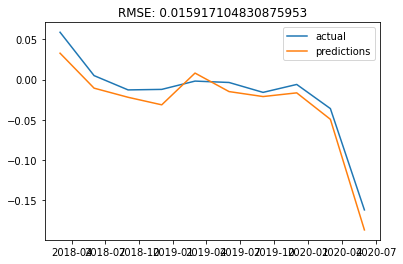

In [53]:
# performance on the test set with default hyperparameters and all variables as a baseline
model = LSTM(training, target, n_timesteps=12, n_models=10)
model.train(quiet=True)

test_preds = model.predict(data, only_actuals_obs=True).loc[lambda x: x.date > train_end_date,:] # passing the full dataset, then filtering only for predictions on dates the model wasn't trained on

# rmse on the test set of the model
rmse = np.sqrt(np.nanmean((test_preds.predictions - test_preds.actuals)**2))

plt.plot(test_preds.date, test_preds.actuals, label="actual") 
plt.plot(test_preds.date, test_preds.predictions, label="predictions")
plt.legend()
plt.title(f"RMSE: {rmse}");

In [64]:
# hyperparameter and variable selection
# checking on artificial vintages with made up publication lags, two months before, month of, and 2 months after vintages
selection_results = select_model(training, target, n_models=10, n_timesteps_grid = [6, 12], train_episodes_grid = [100, 200], batch_size_grid = [30], n_hidden_grid = [10, 20], n_layers_grid = [2], n_folds=5, init_test_size = 0.5, pub_lags = [0, 1, 2, 1, 0], lags = [-2, 0, 2], initial_ordering="univariate")

tuning: 0 / 8
univariate stage: 0 / 5 columns
univariate stage: 1 / 5 columns
univariate stage: 2 / 5 columns
univariate stage: 3 / 5 columns
univariate stage: 4 / 5 columns
multivariate stage: 0 / 5 columns
multivariate stage: 1 / 5 columns
multivariate stage: 2 / 5 columns
multivariate stage: 3 / 5 columns
multivariate stage: 4 / 5 columns
tuning: 1 / 8
univariate stage: 0 / 5 columns
univariate stage: 1 / 5 columns
univariate stage: 2 / 5 columns
univariate stage: 3 / 5 columns
univariate stage: 4 / 5 columns
multivariate stage: 0 / 5 columns
multivariate stage: 1 / 5 columns
multivariate stage: 2 / 5 columns
multivariate stage: 3 / 5 columns
multivariate stage: 4 / 5 columns
tuning: 2 / 8
univariate stage: 0 / 5 columns
univariate stage: 1 / 5 columns
univariate stage: 2 / 5 columns
univariate stage: 3 / 5 columns
univariate stage: 4 / 5 columns
multivariate stage: 0 / 5 columns
multivariate stage: 1 / 5 columns
multivariate stage: 2 / 5 columns
multivariate stage: 3 / 5 columns
mu

In [65]:
selection_results

variables  \
0                      [x_de, x_uk, ipi_cn]   
1                      [x_uk, x_de, ipi_cn]   
2  [x_de, x_uk, x_vol_world2, x_jp, ipi_cn]   
3                [x_uk, x_de, x_jp, ipi_cn]   
4                [x_uk, x_de, x_jp, ipi_cn]   
5  [x_uk, x_de, x_vol_world2, x_jp, ipi_cn]   
6  [x_uk, x_de, x_vol_world2, x_jp, ipi_cn]   
7                [x_de, x_uk, x_jp, ipi_cn]   

                                     hyperparameters  performance  
0  {'n_models': 10, 'n_timesteps': 6, 'fill_na_fu...     0.028915  
1  {'n_models': 10, 'n_timesteps': 12, 'fill_na_f...     0.029574  
2  {'n_models': 10, 'n_timesteps': 6, 'fill_na_fu...     0.029639  
3  {'n_models': 10, 'n_timesteps': 6, 'fill_na_fu...     0.029942  
4  {'n_models': 10, 'n_timesteps': 12, 'fill_na_f...     0.031726  
5  {'n_models': 10, 'n_timesteps': 12, 'fill_na_f...     0.031744  
6  {'n_models': 10, 'n_timesteps': 6, 'fill_na_fu...     0.032668  
7  {'n_models': 10, 'n_timesteps': 12, 'fill_na_f...     0.032927

In [89]:
selection_results.iloc[0,0]

['x_de', 'x_uk', 'ipi_cn']

In [74]:
selection_results.iloc[0,1]

{'n_models': 10,
 'n_timesteps': 6,
 'fill_na_func': <function numpy.nanmean(a, axis=None, dtype=None, out=None, keepdims=<no value>)>,
 'fill_ragged_edges_func': <function numpy.nanmean(a, axis=None, dtype=None, out=None, keepdims=<no value>)>,
 'train_episodes': 200,
 'batch_size': 30,
 'decay': 0.98,
 'n_hidden': 20,
 'n_layers': 2,
 'dropout': 0,
 'criterion': '',
 'optimizer': '',
 'optimizer_parameters': {'lr': 0.01}}

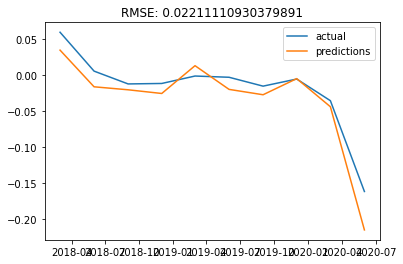

In [90]:
# performance on the test set with selected hyperparameters and variables
model2 = LSTM(training.loc[:, ["date", target] + ['x_de', 'x_uk', 'ipi_cn']], target, n_timesteps=6, n_models=10, train_episodes=200, batch_size=30, n_hidden=20, n_layers=2)
model2.train(quiet=True)

test_preds = model2.predict(data.loc[:, ["date", target] + ['x_de', 'x_uk', 'ipi_cn']], only_actuals_obs=True).loc[lambda x: x.date > train_end_date,:] # passing the full dataset, then filtering only for predictions on dates the model wasn't trained on

# rmse on the test set of the model
rmse = np.sqrt(np.nanmean((test_preds.predictions - test_preds.actuals)**2))

plt.plot(test_preds.date, test_preds.actuals, label="actual") 
plt.plot(test_preds.date, test_preds.predictions, label="predictions")
plt.legend()
plt.title(f"RMSE: {rmse}");

In this particular case we can see that the hyperparameter tuning and variable selection decreased the number of variables by 40% and increased accuracy prior to Q2 2020, but worsened results slightly for that quarter, which dragged overall RMSE down. This could probably be fixed by taking the three selected variables and running a deeper grid search with them.

# Uncertainty intervals <a class="anchor" id="bullet-10"></a>
An important component of using the predictions of any model is uncertainty. The _nowcast\_lstm_ library has functionality built in to approximate uncertainty via the `interval_predict()` and `ragged_interval_predict()` functions. It is important to note that this particular implementation is still in testing and validation.

There are several approaches to quantifying uncertainty in a neural network's predictions. One approach is to use dropout between hidden layers as a Bayesian approximator. For more information, see [this](https://arxiv.org/abs/1709.01907) or [this](https://arxiv.org/abs/1506.02142) paper. In this case, the approach was not suitable because LSTM networks with only one hidden layer are viable and often well-performing models. In this case, there is nowhere to perform dropout. Alternatively, the network could be reworked into a Bayesian Neural Network (BNN). For more information, see [this](https://www.sciencedirect.com/science/article/abs/pii/S0045782521004102) paper. However, this would require an extensive overhaul of the existing modelling framework just to get uncertainty intervals. Therefore, an implementation that could be applied to the existing architecture was needed.

In the nowcasting case, there are two main types of uncertainty which need to be captured:
- **data availability uncertainty**: this uncertainty captures the fact that at different times during the prediction period there are differing amounts of information available to the model. Early in the prediction period, there may be almost no information available, nothing has been published yet. At the end of the prediction period, almost all of the data is available to the model. This uncertainty should then decrease as more and more information becomes available. 
- **model uncertainty**: this captures the inherent uncertainty of the model given the underyling data. This is sometimes referred to as epistemic uncertainty. It could be due to a lack of training data or lack of relevant input variables.

The first type of uncertainty is approximated in the library by combining the proportion of data available to the model with the standard deviation of the target variable. For instance, at an early period with zero data available to the model, it will only be able to predict the target series mean. What should the uncertainty interval be in this case? If we specify an interval of 0.95 (95%), assuming the target variable is normally distributed, that means if we take 1.96 standard deviations from either side of the series mean, we should cover about 95% of historical observations. If we specify an interval of 0.99 (99%), if we take 2.58 standard deviations from either side of the series mean, we should cover about 99% of historical observations. With no other information to go on, this is a reasonable starting point for our uncertainty intervals.

As more information is published, we can reduce this uncertainty as the model takes into account the new information. In the library, this is implemented by multiplyling this interval by the percent of data missing from the model for inference. With a 0.95 interval, when 0% of the data is available for inference, 1.96 standard deviations of the target series will be added and subtracted from the upper and lower quantiles of the networks' predictions (more information below). When 50% is available, 0.98 standard deviations will be added and subtracted, etc.

Luckily, neural networks already have an inbuilt method of approximating model uncertainty. Because the models are stochastic, different networks trained on the same data will produce different estimates. These different estimates can be interpreted as a Gaussian prediction interval. We can then take the quantiles (e.g., 97.5 and 2.5 percentiles for a 0.95 interval) of these different estimates as a measure of model uncertainty. **To improve both prediction and interval qualities, use more networks when training (the `n_models` parameter in `LSTM`). At least 10 models, potentially even 100 or more.**

By combining these two uncertainties together, we can obtain uncertainty intervals. The two are combined by adding and subtracting the data availability adjustment to/from the upper and lower quantiles of the networks' predictions. As a result, the upper and lower intervals may not be symmetric. But as `n_models` increases, the intervals will become more and more symmetric. The more data are published, data availability uncertainty will decrease, while model uncertainty may increase, decrease, or stay the same. Therefore, it is no guarantee that overall uncertainty intervals will decrease with more data. It may be that the decrease in data availability uncertainty is more than offset by model uncertainty. E.g., if the signals coming in from the new data are mixed or extreme, the networks may diverge in their predictions.

Below are examples and illustrations of the methodology in action.

In [3]:
# data read
data = pd.read_csv("data.csv", parse_dates=["date"])
data = data.loc[:, ["date", "x_jp", "x_world", "x_de", "x_uk", "ipi_cn", "x_vol_world2"]] # random subset of columns for simplicity
train_end_date = "2017-12-01" # training data through 2017
training = data.loc[data.date <= train_end_date,:]

In [33]:
# training a model
model = LSTM(data=training, target_variable="x_world", n_timesteps=12, n_models=50, train_episodes=50)
model.train(quiet=True)

The `interval_predict()` function outputs identical predictions to the `predict()` function, with the addition of two new columns, `lower_interval` and `upper interval`.

In [34]:
interval_preds_99 = model.interval_predict(data, interval=0.99, only_actuals_obs=True, start_date="2018-12-01", end_date="2019-12-01")
interval_preds_99

date   actuals  predictions  lower_interval  upper_interval
0 2018-12-01 -0.012139    -0.016433       -0.041602        0.019484
1 2019-03-01 -0.001823    -0.000773       -0.031290        0.021295
2 2019-06-01 -0.003545     0.000986       -0.023401        0.022013
3 2019-09-01 -0.015856    -0.005898       -0.027331        0.019723
4 2019-12-01 -0.005995    -0.011324       -0.033998        0.020502

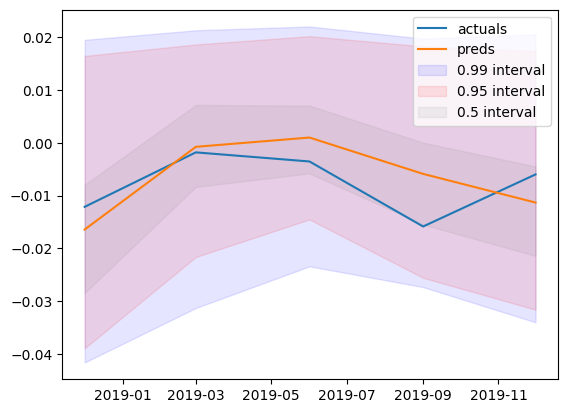

In [35]:
# other intervals to illustrate difference
interval_preds_95 = model.interval_predict(data, interval=0.95, only_actuals_obs=True, start_date="2018-12-01", end_date="2019-12-01")
interval_preds_50 = model.interval_predict(data, interval=0.5, only_actuals_obs=True, start_date="2018-12-01", end_date="2019-12-01")

# plotting 
fig, ax = plt.subplots()
ax.plot(interval_preds_99.date,interval_preds_99.actuals, label="actuals")
ax.plot(interval_preds_99.date,interval_preds_99.predictions, label="preds")
ax.fill_between(interval_preds_99.date, interval_preds_99.lower_interval, interval_preds_99.upper_interval, color='b', alpha=.1, label="0.99 interval")
ax.fill_between(interval_preds_95.date, interval_preds_95.lower_interval, interval_preds_95.upper_interval, color='r', alpha=.1, label="0.95 interval")
ax.fill_between(interval_preds_50.date, interval_preds_50.lower_interval, interval_preds_50.upper_interval, color='grey', alpha=.1, label="0.5 interval")
plt.legend()

In the above example, the intervals come essentially 100% from model uncertainty, since the data is fully available for inference. If you would like to test how the intervals look with synthetic vintages, use the `ragged_interval_predict()` function.

In [36]:
pub_lags = [1 for i in range(len(data.columns)-2)] # just assume 1 month publication lag for each variable for simplicity
ragged_interval_preds = model.ragged_interval_predict(data=data, pub_lags=pub_lags, lag=-2, interval=0.95, start_date="2018-12-01", end_date="2019-12-01")

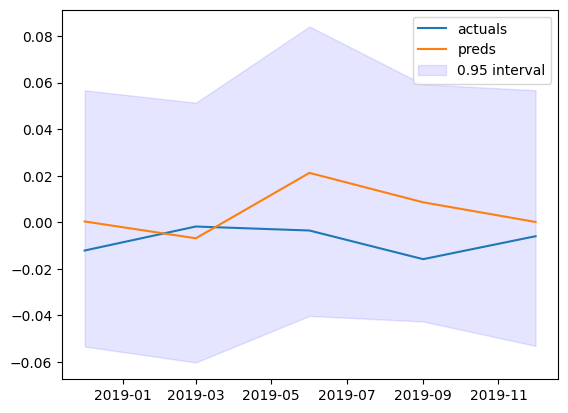

In [37]:
# plotting 
fig, ax = plt.subplots()
ax.plot(ragged_interval_preds.date,ragged_interval_preds.actuals, label="actuals")
ax.plot(ragged_interval_preds.date,ragged_interval_preds.predictions, label="preds")
ax.fill_between(ragged_interval_preds.date, ragged_interval_preds.lower_interval, ragged_interval_preds.upper_interval, color='b', alpha=.1, label="0.95 interval")
plt.legend()

With an artificially simulated vintage of 2 months before, we see that predictions are worse while the uncertainty intervals are larger. Below, we examine a single target period over several lags to see how uncertainty intervals develop.

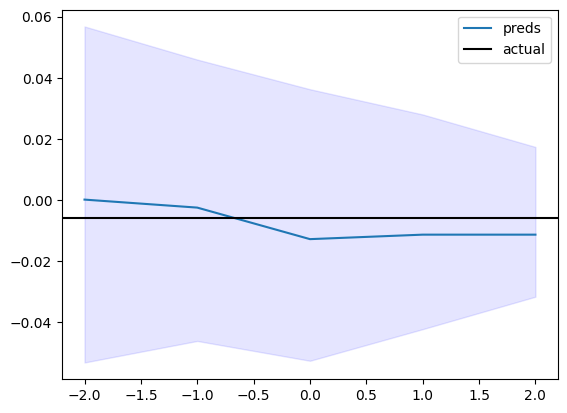

In [38]:
target_period = "2019-12-01"
interval = 0.95
actual = data.loc[data.date == target_period, "x_world"].values[0]
point_preds = []
lower = []
upper = []
for lag in range(-2,3):    
    preds = model.ragged_interval_predict(data=data, pub_lags=pub_lags, lag=lag, interval=interval, start_date=target_period, end_date=target_period)
    point_preds.append(preds.loc[0,"predictions"])
    lower.append(preds.loc[0,"lower_interval"])
    upper.append(preds.loc[0,"upper_interval"])

pred_df = pd.DataFrame({
    "lag": range(-2,3),
    "pred": point_preds,
    "lower": lower,
    "upper": upper
})

fig, ax = plt.subplots()
ax.plot(range(-2,3),pred_df.pred, label="preds")
ax.fill_between(range(-2,3), pred_df.lower, pred_df.upper, color='b', alpha=.1)
plt.axhline(y = actual, color = 'black', linestyle = '-', label="actual")

plt.legend()

We see that, in this case, the uncertainty intervals decrease as more data are released.

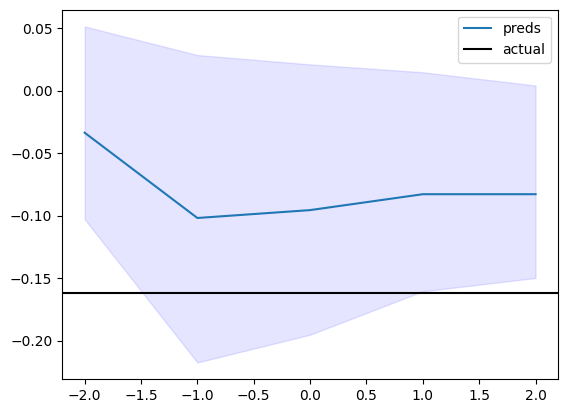

In [43]:
target_period = "2020-06-01"
interval = 0.95
actual = data.loc[data.date == target_period, "x_world"].values[0]
point_preds = []
lower = []
upper = []
for lag in range(-2,3):    
    preds = model.ragged_interval_predict(data=data, pub_lags=pub_lags, lag=lag, interval=interval, start_date=target_period, end_date=target_period)
    point_preds.append(preds.loc[0,"predictions"])
    lower.append(preds.loc[0,"lower_interval"])
    upper.append(preds.loc[0,"upper_interval"])

pred_df = pd.DataFrame({
    "lag": range(-2,3),
    "pred": point_preds,
    "lower": lower,
    "upper": upper
})

fig, ax = plt.subplots()
ax.plot(range(-2,3),pred_df.pred, label="preds")
ax.fill_between(range(-2,3), pred_df.lower, pred_df.upper, color='b', alpha=.1)
plt.axhline(y = actual, color = 'black', linestyle = '-', label="actual")

plt.legend()

Monotonic shrinking of the uncertainty interval is not the case in Q2 2020. Going from the 2 months before to the 1 month before vintage, we can see that the interval actually expands. This is because, while data availability uncertainty decreased, there were very extreme data published. This increased model uncertainty.